In [4]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import ijson
import seaborn as sns

In [5]:
def load_trajectories(file_path, trajectory_timeframe = pd.Timedelta(minutes=10)):
    westbound_trajectories = []
    t_min = 0  # Initialize to latest possible timestamp
    t_max = 0  # Initialize to earliest possible timestamp
    set_min_time = False
    
    # Open file and stream data
    with open(file_path, "r") as f:
        trajectory_iterator = ijson.items(f, "item")  # Assuming JSON is a list of trajectories
        for i,traj in enumerate(trajectory_iterator):
            x_positions = traj.get("x_position", [])
    
            # Ensure we have enough points to determine direction
            if len(x_positions) > 1:
                if x_positions[-1] < x_positions[0]:  # Check if x is decreasing over time
                    westbound_trajectories.append(traj)
                    timestamps = [float(num) for num in traj.get("timestamp")]
                    timestamps = pd.to_datetime(timestamps, unit = "s")
                    if not set_min_time:
                        t_min = timestamps[0]
                        set_min_time = True
                    t_max = timestamps[0]
                    if t_max-t_min > trajectory_timeframe:
                        print("t max", t_max)
                        print("t min", t_min)
                        break
    
    print(f"Loaded {len(westbound_trajectories)} westbound trajectories.")
    # Flatten westbound trajectories into a DataFrame with trajectory_id
    records = []
    for traj_id, traj in enumerate(westbound_trajectories):  # Assign unique ID to each trajectory
        # print(traj["timestamp"])
        for i in range(len(traj["timestamp"])):
            records.append({
                "trajectory_id": traj_id,  # Add trajectory ID
                "timestamp": traj["timestamp"][i],
                "x_position": traj["x_position"][i],
                "speed": traj["y_position"][i] if "y_position" in traj else np.nan  # Use real speed if available
            })
    
    print(traj_id)
    df = pd.DataFrame(records)
    # Convert timestamp to datetime format if not done earlier
    df["timestamp"] = df["timestamp"].astype("float")
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
    # Debugging: Check column names and first few rows
    print(df.columns.tolist())  # Should include 'trajectory_id'
    print(df)
    return df

In [61]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
westbound_trajectories_10_mins_df = load_trajectories(file_path, pd.Timedelta(minutes=10))

t max 2022-11-30 12:10:00.200000048
t min 2022-11-30 11:59:59.900000095
Loaded 3455 westbound trajectories.
3454
['trajectory_id', 'timestamp', 'x_position', 'speed']
        trajectory_id                     timestamp          x_position  \
0                   0 2022-11-30 11:59:59.900000095  315850.09783643583   
1                   0 2022-11-30 11:59:59.940000057   315845.5643252045   
2                   0 2022-11-30 11:59:59.980000019  315841.03489504935   
3                   0 2022-11-30 12:00:00.020000219  315836.50955000444   
4                   0 2022-11-30 12:00:00.060000181   315831.9882974884   
...               ...                           ...                 ...   
466781           3454 2022-11-30 12:10:00.920000076    314644.257617663   
466782           3454 2022-11-30 12:10:00.960000038   314641.0732147664   
466783           3454 2022-11-30 12:10:01.000000000   314637.8814866535   
466784           3454 2022-11-30 12:10:01.040000200  314634.68245173537   
466785  

In [6]:
def get_flow_speed_matrix(df, time_interval=pd.Timedelta(minutes=1), space_interval=100):
    # Compute min/max for time and space
    t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
    x_min, x_max = df["x_position"].min(), df["x_position"].max()
    
    # Ensure valid ranges
    if x_min == x_max:
        raise ValueError("x_min and x_max are identical, meaning no variation in x_position.")
    
    # Create time and space bins
    time_bins = pd.date_range(start=t_min, end=t_max, freq=time_interval)
    space_bins = np.arange(x_min, x_max + space_interval, space_interval)
    
    if len(space_bins) < 2:
        raise ValueError("space_bins array is empty or too small, adjust space_interval.")
    
    # Assign bin indices using `pd.cut()`
    df["time_bin"] = pd.cut(df["timestamp"], bins=time_bins, labels=False, include_lowest=True)
    df["space_bin"] = pd.cut(df["x_position"], bins=space_bins, labels=False, include_lowest=True)

    # Remove NaNs (out-of-range values)
    df = df.dropna(subset=["time_bin", "space_bin"]).astype({"time_bin": int, "space_bin": int})

    # Compute flow and speed using `groupby()`
    flow_matrix = np.zeros((len(time_bins) - 1, len(space_bins) - 1))
    speed_matrix = np.zeros_like(flow_matrix)

    grouped = df.groupby(["time_bin", "space_bin"])
    flow_counts = grouped.size().unstack(fill_value=0)  # Flow: count per bin
    speed_means = grouped["speed"].mean().unstack(fill_value=0) if "speed" in df.columns else None

    # Populate matrices
    flow_matrix[:flow_counts.shape[0], :flow_counts.shape[1]] = flow_counts.values
    if speed_means is not None:
        speed_matrix[:speed_means.shape[0], :speed_means.shape[1]] = speed_means.values

    return flow_matrix, speed_matrix

In [7]:
def plot_matrices(flow_matrix, speed_matrix, time_increment, space_increment, t_min, t_max, x_min, x_max):

    plt.figure(figsize=(12, 6))

    # Compute reasonable tick marks
    num_time_bins = flow_matrix.shape[0]
    num_space_bins = flow_matrix.shape[1]

    time_ticks = np.linspace(0, num_time_bins - 1, min(10, num_time_bins)).astype(int)
    space_ticks = np.linspace(0, num_space_bins - 1, min(10, num_space_bins)).astype(int)

    time_labels = [(t_min + i * time_increment).strftime("%H:%M") for i in time_ticks]
    space_labels = [int(x_min + i * space_increment) for i in space_ticks]

    # Create heatmap for flow matrix
    ax1 = plt.subplot(1, 2, 1)
    sns.heatmap(flow_matrix.T, cmap="YlGnBu", xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Flow (vehicles)'})
    plt.title(f"Time-Space Diagram of Vehicle Flow\n{time_increment} minutes, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    ax1.invert_yaxis()  # Reverse the y-axis

    # Plot the speed matrix
    ax2 = plt.subplot(1, 2, 2)
    sns.heatmap(speed_matrix.T, cmap="coolwarm", xticklabels=time_labels, yticklabels=space_labels[::-1], cbar_kws={'label': 'Average Speed (m/s)'})
    plt.title(f"Time-Space Diagram of Vehicle Speed\n{time_increment} minutes, {space_increment} meters")
    plt.xlabel("Time")
    plt.ylabel("Space (meters)")
    plt.xticks(time_ticks, time_labels, rotation=45)
    plt.yticks(space_ticks, space_labels)
    ax2.invert_yaxis()  # Reverse the y-axis

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [66]:
# 100m, 1 minute
flow_1min_100m, speed_1min_100m = get_flow_speed_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100)

# 100m, 10 sec
flow_10sec_100m, speed_10sec_100m = get_flow_speed_matrix(westbound_trajectories_10_mins_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100)


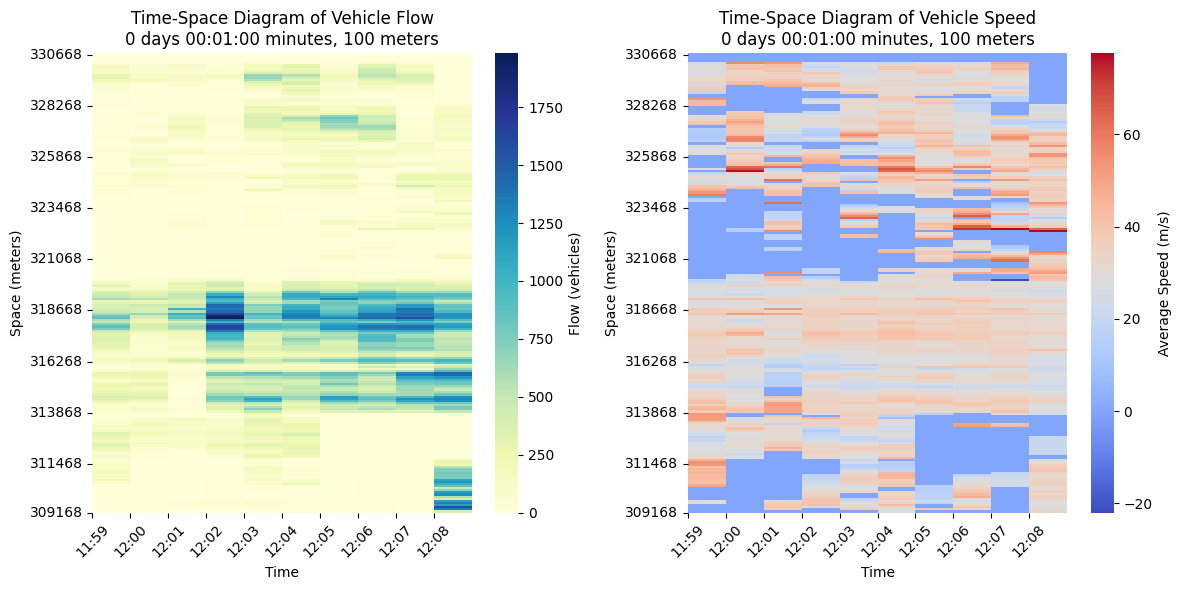

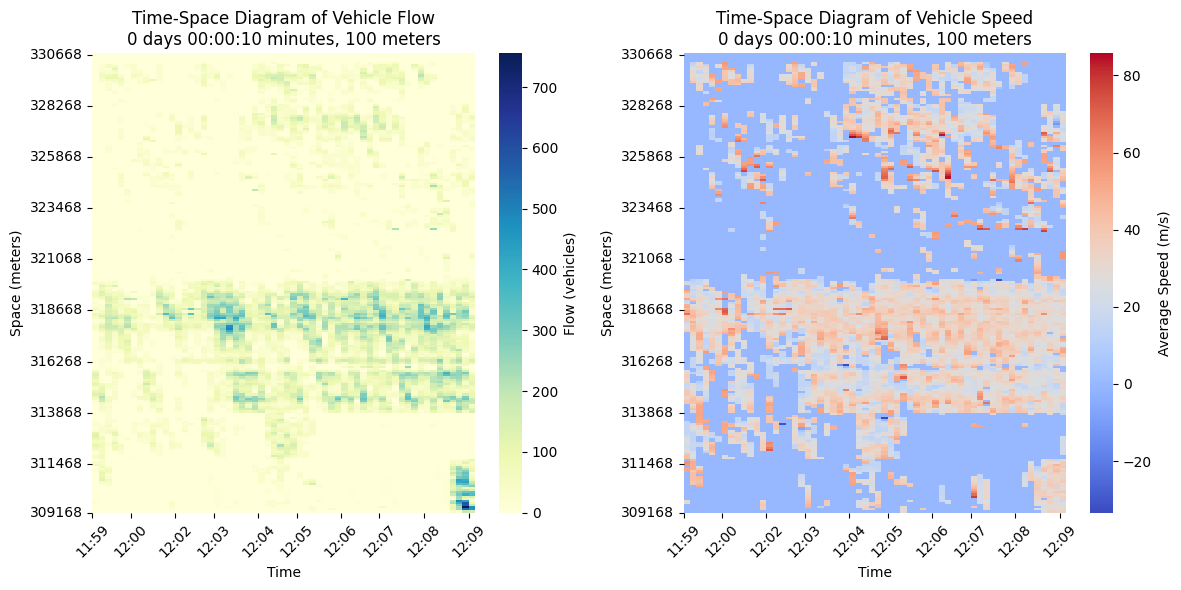

In [67]:
t_min, t_max = df["timestamp"].min(), df["timestamp"].max()
x_min, x_max = df["x_position"].min(), df["x_position"].max()
plot_matrices(flow_1min_100m, speed_1min_100m, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)
plot_matrices(flow_10sec_100m, speed_10sec_100m, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)

In [8]:
input_filename = "6386d89efb3ff533c12df167__post10.json"
file_path = os.path.join("/Users/MonicaChan/Desktop/wu-lab/data_tutorial/11-30-2022/", input_filename)
westbound_trajectories_1_hr_df = load_trajectories(file_path, pd.Timedelta(hours=1))

t max 2022-11-30 13:00:00.400000095
t min 2022-11-30 11:59:59.900000095
Loaded 137900 westbound trajectories.
137899
['trajectory_id', 'timestamp', 'x_position', 'speed']
          trajectory_id                     timestamp          x_position  \
0                     0 2022-11-30 11:59:59.900000095  315850.09783643583   
1                     0 2022-11-30 11:59:59.940000057   315845.5643252045   
2                     0 2022-11-30 11:59:59.980000019  315841.03489504935   
3                     0 2022-11-30 12:00:00.020000219  315836.50955000444   
4                     0 2022-11-30 12:00:00.060000181   315831.9882974884   
...                 ...                           ...                 ...   
47826823         137899 2022-11-30 13:00:01.920000076   321848.0536225125   
47826824         137899 2022-11-30 13:00:01.960000038  321844.84178662545   
47826825         137899 2022-11-30 13:00:02.000000000   321841.6203927772   
47826826         137899 2022-11-30 13:00:02.040000200  3218

In [9]:
flow_1min_100m_1hr, speed_1min_100m_1hr = get_flow_speed_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(minutes=1), space_interval = 100)


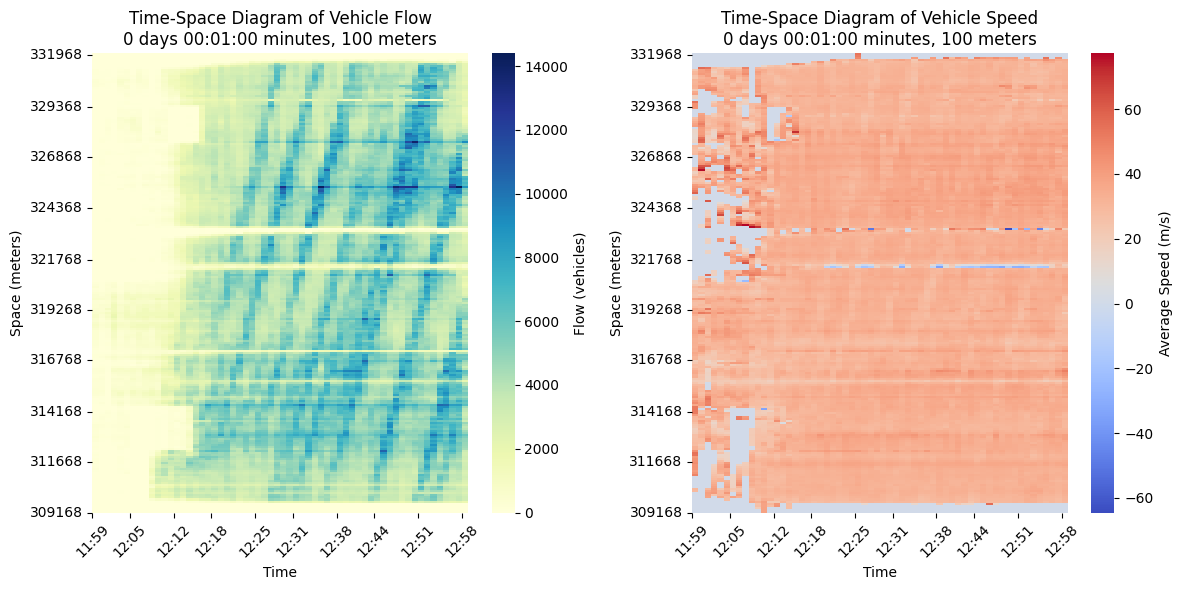

In [10]:
t_min, t_max = westbound_trajectories_1_hr_df["timestamp"].min(), westbound_trajectories_1_hr_df["timestamp"].max()
x_min, x_max = westbound_trajectories_1_hr_df["x_position"].min(), westbound_trajectories_1_hr_df["x_position"].max()
plot_matrices(flow_1min_100m_1hr, speed_1min_100m_1hr, pd.Timedelta(minutes=1), 100, t_min, t_max, x_min, x_max)


In [11]:
flow_10sec_100m_1hr, speed_10sec_100m_1hr = get_flow_speed_matrix(westbound_trajectories_1_hr_df, time_interval = pd.Timedelta(seconds=10), space_interval = 100)


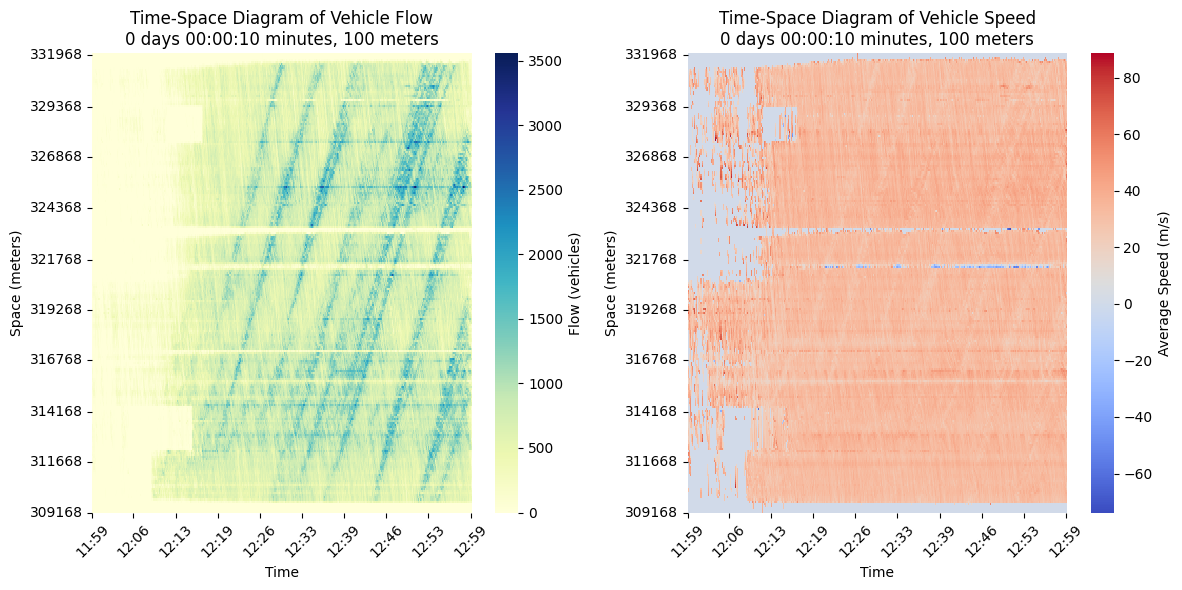

In [12]:
plot_matrices(flow_10sec_100m_1hr, speed_10sec_100m_1hr, pd.Timedelta(seconds=10), 100,  t_min, t_max, x_min, x_max)